* Formation Continue EMIASD, Univ. Paris Dauphine, Promo 6

* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr
* Reusing without consent of the author is strictly forbidden
* July 2025



# Homework


## Prerequis

### System setup

In [17]:
%%capture
!pip install pyspark==3.5.3
!pip install -q delta-spark==3.2.1
!pip install pyngrok

In [18]:
!pip list|grep spark

dataproc-spark-connect                0.8.3
delta-spark                           3.2.1
pyspark                               3.5.3


In [19]:
from pyspark import SparkConf
# from pyspark.context import SparkContext
from pyspark.sql import SparkSession

local = "local[*]"
appName = "Formation Continue EMIASD - Delta Lake "
localConfig = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "8G").\
  set("spark.driver.memory","8G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.sql.extensions","io.delta.sql.DeltaSparkSessionExtension").\
  set("spark.sql.catalog.spark_catalog","org.apache.spark.sql.delta.catalog.DeltaCatalog").\
  set("spark.jars.packages","io.delta:delta-spark_2.12:3.1.0").\
  set("spark.databricks.delta.schema.autoMerge.enabled","true")

spark = SparkSession.builder.config(conf = localConfig).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [20]:
spark

### Data import

In [21]:
%%capture
!wget --no-verbose https://nuage.lip6.fr/s/89BG8HD9r3iE693/download/MLData.tgz -O /tmp/MLData.tgz
!tar -xzvf /tmp/MLData.tgz  --directory /tmp/

In [22]:
!ls -hal /tmp/MLData

total 73M
drwxr-xr-x 2  501 staff 4.0K Jan  6  2022 .
drwxrwxrwt 1 root root  4.0K Sep 14 17:46 ..
-rw-r--r-- 1  501 staff  66M Jan  6  2022 autos.csv
-rw-r--r-- 1  501 staff  176 Jan  6  2022 ._loan.csv
-rw-r--r-- 1  501 staff 6.8M Jan  6  2022 loan.csv


In [23]:
query = """
CREATE TABLE IF NOT EXISTS raw_vehiculePrices
USING csv
OPTIONS (
  header "true",
  path "/tmp/MLData/autos.csv",
  inferSchema "true"
)
"""
spark.sql(query)

DataFrame[]

## Phase 0: Comprendre les données

Dans cette partie, nous allons nous familiariser avec les données en lisant leur schéma et en extrayant quelques informations statistiques de base sur les valeurs des colonnes que vous jugerez intéressantes.

### Informations globales sur le jeu de données des données

In [ ]:
query = """
DESCRIBE raw_vehiculePrices
"""
spark.sql(query).show()

+-------------------+---------+-------+
|           col_name|data_type|comment|
+-------------------+---------+-------+
|        dateCrawled|timestamp|   NULL|
|               name|   string|   NULL|
|             seller|   string|   NULL|
|          offerType|   string|   NULL|
|              price|      int|   NULL|
|             abtest|   string|   NULL|
|        vehicleType|   string|   NULL|
| yearOfRegistration|      int|   NULL|
|            gearbox|   string|   NULL|
|            powerPS|      int|   NULL|
|              model|   string|   NULL|
|          kilometer|      int|   NULL|
|monthOfRegistration|      int|   NULL|
|           fuelType|   string|   NULL|
|              brand|   string|   NULL|
|  notRepairedDamage|   string|   NULL|
|        dateCreated|timestamp|   NULL|
|       nrOfPictures|      int|   NULL|
|         postalCode|      int|   NULL|
|           lastSeen|timestamp|   NULL|
+-------------------+---------+-------+



In [ ]:
query = """
SELECT * FROM raw_vehiculePrices TABLESAMPLE (5 ROWS);
"""
spark.sql(query).show()


+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|        dateCrawled|                name|seller|offerType|price|abtest|vehicleType|yearOfRegistration|  gearbox|powerPS|model|kilometer|monthOfRegistration|fuelType|     brand|notRepairedDamage|        dateCreated|nrOfPictures|postalCode|           lastSeen|
+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+-----+---------+-------------------+--------+----------+-----------------+-------------------+------------+----------+-------------------+
|2016-03-24 11:52:17|          Golf_3_1.6|privat|  Angebot|  480|  test|       NULL|              1993|  manuell|      0| golf|   150000|                  0|  benzin|volkswagen|             NULL|2016-03-24 00:00:00|     

In [ ]:
query = """
SELECT count(*) FROM raw_vehiculePrices ;
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|  371824|
+--------+



Le jeu de données représente des véhicules ayant déjà été mis en circulation. Les véhicules sont plus ou moins anciens et de tous les modèles.

Nous allons donc partir de l'idée qu'il s'agit de la base de données d'un site de revente de véhicules d'occasion.

Nous allons, à partir des données les plus pertinentes, établir quelques statistiques afin d'aider les gérants de ce site à mieux comprendre leur parc automobile pour améliorer leurs ventes.

## Phase 1 : Nettoyage des données et suppression des données non pertinentes

### Etude des données relatives au modèle de véhicule

Nous allons maintenant travailler sur les données définissant le véhicule lui même afin de voir quelles données sont les plus pertinentes à conserver dans notre jeu de données finale.

In [ ]:
query = """
SELECT name, brand, vehicleType
FROM raw_vehiculePrices
WHERE model IS NULL
"""
spark.sql(query).show()

+--------------------+--------------+-----------+
|                name|         brand|vehicleType|
+--------------------+--------------+-----------+
|A5_Sportback_2.7_Tdi|          audi|      coupe|
|TAUSCHE_BMW_E38_7...|sonstige_autos|        suv|
|Bastler_Fahrzeug_...|          fiat| kleinwagen|
|Polo_6n_Karosse_z...|    volkswagen| kleinwagen|
|Audi_80_5_Zylinde...|          audi|  limousine|
|POLO_1.2_KILIMA_W...|    volkswagen| kleinwagen|
|          is_ales_ok|       renault| kleinwagen|
|VW_Caddy_Lkw_Zula...|    volkswagen|      kombi|
|BMW_530xd_e60_EZ1...|           bmw|  limousine|
|VW_Polo_Coupe_86c...|    volkswagen|      coupe|
|Mitsubishi_Colt_T...|    mitsubishi|       NULL|
|Audi_80_coupe_top...|          audi|      coupe|
|Tauache_90ccm_rol...|sonstige_autos|       NULL|
|Biete_BMW_318_i_K...|           bmw|      kombi|
|   Peugeot_107_Klima|       peugeot| kleinwagen|
|Peugeot__F__206_m...|       peugeot| kleinwagen|
|        Corvette_Z06|sonstige_autos|     cabrio|


Le nom des véhicules ne respecte pas de format permettant d'en tirer des informations globales ou générales.

Nous pouvons difficilement l'utiliser dans des requêtes de statistiques plus globales.  

In [ ]:
query = """
SELECT count(*)
FROM raw_vehiculePrices
WHERE model IS NULL  and vehicleType IS NULL;
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|    6919|
+--------+



In [ ]:
query = """
SELECT count(*)
FROM raw_vehiculePrices
WHERE brand IS NULL ;
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|       1|
+--------+



Nous pouvons partir du principe qu'un véhicule n'ayant ni le model ni le type de renseigné, ne sera jamais consulté et aura donc très peu de chances d'être vendu.

Il pourrait donc être opportun de ne pas les prendre en compte dans nos statistiques finales.

Nous pouvons également imposer la marque comme donnée obligatoire étant donné qu'elle est toujours, à une exception prêt, renseignée.

**En conclusion, nous souhaitons imposer aux données finales les contraintes suivantes :**
<font color="##3C16D9">
* marque obligatoire
* modèle ou type de véhicule obligatoire
</font>

### Etudes données de type Date

Essayons maintenant de comprendre les différentes dates présentes dans le jeu de données.

In [ ]:
query = """
SELECT  min(yearOfRegistration), max(yearOfRegistration),
          avg(yearOfRegistration), median(yearOfRegistration)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+-----------------------+-----------------------+-----------------------+--------------------------+
|min(yearOfRegistration)|max(yearOfRegistration)|avg(yearOfRegistration)|median(yearOfRegistration)|
+-----------------------+-----------------------+-----------------------+--------------------------+
|                   1000|                   9999|     2004.5767206439623|                    2003.0|
+-----------------------+-----------------------+-----------------------+--------------------------+



In [ ]:
query = """
SELECT dateCreated, lastSeen, dateCrawled
FROM raw_vehiculePrices
WHERE model IS NULL  and vehicleType IS NULL;
"""
spark.sql(query).show(10)

+-------------------+-------------------+-------------------+
|        dateCreated|           lastSeen|        dateCrawled|
+-------------------+-------------------+-------------------+
|2016-04-04 00:00:00|2016-04-06 11:17:11|2016-04-04 09:49:59|
|2016-03-21 00:00:00|2016-03-24 02:47:34|2016-03-21 14:38:37|
|2016-03-27 00:00:00|2016-04-05 15:15:29|2016-03-27 18:43:25|
|2016-03-24 00:00:00|2016-03-30 18:16:07|2016-03-24 16:46:05|
|2016-03-24 00:00:00|2016-03-29 03:45:06|2016-03-24 17:49:19|
|2016-03-14 00:00:00|2016-03-14 18:40:14|2016-03-14 18:40:14|
|2016-03-25 00:00:00|2016-03-26 07:44:30|2016-03-25 22:53:44|
|2016-03-15 00:00:00|2016-04-06 14:45:44|2016-03-15 17:43:21|
|2016-03-21 00:00:00|2016-03-22 14:50:41|2016-03-21 10:52:52|
|2016-03-16 00:00:00|2016-03-20 16:44:37|2016-03-16 16:55:09|
+-------------------+-------------------+-------------------+
only showing top 10 rows



La date de création et d'exploration semblent être identique. Vérifions cette hypothèse.

In [ ]:
query = """
SELECT DATEDIFF(dateCreated, dateCrawled)
FROM raw_vehiculePrices
order by DATEDIFF(dateCreated, dateCrawled) desc ;
"""
spark.sql(query).show(5)

+----------------------------------+
|datediff(dateCreated, dateCrawled)|
+----------------------------------+
|                                 0|
|                                 0|
|                                 0|
|                                 0|
|                                 0|
+----------------------------------+
only showing top 5 rows



Notre hypothèse se vérifie donc.

Nous allons uniquement conserver la date de création.

In [ ]:
query = """
SELECT count(yearOfRegistration)
FROM raw_vehiculePrices
WHERE yearOfRegistration > 2025 OR yearOfRegistration < 1900
"""
spark.sql(query).show()

+-------------------------+
|count(yearOfRegistration)|
+-------------------------+
|                      182|
+-------------------------+



Les lignes représentant des véhicules dont l'année de mise en circulation est soit trop ancienne soit dans le futur peuvent également erroner les statitisques souhaitées. En effet l'age d'un véhicule est primordial pour sa revente.

Nous allons malgré tout les analyser de plus prêt pour pouvoir en tirer des conclusions sur leur pertinence.

In [ ]:
query = """
SELECT vehicleType, model, brand, price, yearOfRegistration
FROM raw_vehiculePrices
WHERE yearOfRegistration > 2025 OR yearOfRegistration < 1900
"""
spark.sql(query).show(10)

+-----------+-------+--------------+-----+------------------+
|vehicleType|  model|         brand|price|yearOfRegistration|
+-----------+-------+--------------+-----+------------------+
|       NULL|   NULL|          opel|    0|              1111|
|       NULL|   golf|    volkswagen|   49|              5000|
|       NULL|   NULL|sonstige_autos|    0|              9999|
|       NULL|   NULL|sonstige_autos| 1700|              3200|
|       NULL| mondeo|          ford|  190|              1000|
|       NULL| andere|          opel|  700|              9999|
|       NULL|   NULL|sonstige_autos| 6500|              8888|
|       NULL|impreza|        subaru| 7999|              1500|
|       NULL| twingo|       renault|  300|              2200|
|       NULL|   NULL|sonstige_autos| 1600|              4100|
+-----------+-------+--------------+-----+------------------+
only showing top 10 rows



In [ ]:
query = """
SELECT count(yearOfRegistration)
FROM raw_vehiculePrices
WHERE yearOfRegistration > 2025 OR yearOfRegistration < 1900
AND (model IS null OR vehicleType IS NULL)
"""
spark.sql(query).show(10)

+-------------------------+
|count(yearOfRegistration)|
+-------------------------+
|                      182|
+-------------------------+



Nous constatons que tous les véhicules enregistrés avec des dates de mise en circulation aberrantes, sont également enregistrés avec des données manquantes et pourtant essentielles comme le model ou la marque .

Il sera difficile d'obtenir des informations pertinentes à partir de ces enregistrements aux dates aberrantes, nous ne les conserverons pas dans nos statistiques finales.

<br/>

**En conclusion nous souhaitons conserver :**
<font color="#3C16D9">
* uniquement les enregistrements tels que l'année de mise en circulation est supérieure à 1900 et inférieure à 2025
* uniquement la date de création de l'enregistrement qui devrait correspondre à la date de mise en vente du véhicule et la date de dernière vue du véhicule
</font>

### Incidence du nombre de dommages non réparés

In [ ]:
query = """
SELECT count(*), notRepairedDamage FROM raw_vehiculePrices group by notRepairedDamage;
"""
spark.sql(query).show()

+--------+-----------------+
|count(1)|notRepairedDamage|
+--------+-----------------+
|  263390|             nein|
|   72124|             NULL|
|   36310|               ja|
+--------+-----------------+



In [ ]:
query = """
SELECT DATEDIFF(lastSeen, dateCreated)
FROM raw_vehiculePrices
WHERE notRepairedDamage in ('nein')
order by DATEDIFF(lastSeen, dateCreated) desc ;
"""
spark.sql(query).show(10)

+-------------------------------+
|datediff(lastSeen, dateCreated)|
+-------------------------------+
|                            384|
|                            244|
|                            239|
|                            209|
|                            152|
|                            150|
|                            149|
|                            146|
|                            144|
|                            141|
+-------------------------------+
only showing top 10 rows



In [ ]:
query = """
SELECT DATEDIFF(lastSeen, dateCreated)
FROM raw_vehiculePrices
WHERE notRepairedDamage in ('ja')
order by DATEDIFF(lastSeen, dateCreated) desc ;
"""
spark.sql(query).show(10)

+-------------------------------+
|datediff(lastSeen, dateCreated)|
+-------------------------------+
|                            193|
|                            193|
|                             68|
|                             64|
|                             59|
|                             59|
|                             56|
|                             55|
|                             49|
|                             45|
+-------------------------------+
only showing top 10 rows



Il ne semble pas y avoir d'incidence sur le nombre de dommages non réparés et le fait que les véhicules restent plus longtemps en vente (même des véhicules sans dommages ne sont pas consultés et donc pas achetés sur le site).

In [ ]:
query = """
SELECT count(price), min(price), max(price),
          avg(price), median(price), vehicleType
FROM raw_vehiculePrices
WHERE notRepairedDamage in ('ja')
GROUP BY vehicleType
"""
spark.sql(query).show()

+------------+----------+----------+------------------+-------------+-----------+
|count(price)|min(price)|max(price)|        avg(price)|median(price)|vehicleType|
+------------+----------+----------+------------------+-------------+-----------+
|        3902|         0|  10000000| 6338.087134802665|        500.0|       NULL|
|        1651|         0|  99999999| 64702.99333737129|       1300.0|      coupe|
|        9009|         0|  12345678| 3834.321123321123|        600.0| kleinwagen|
|        2979|         0|     44000| 2922.638469284995|       1650.0|        bus|
|         486|         0|2147483647|4420475.9794238685|        899.5|     andere|
|        8785|         0|    999990|  2478.32578258395|       1000.0|  limousine|
|        1265|         0|    110000| 3553.460079051383|       1555.0|     cabrio|
|         941|         0|    100000| 5532.258235919235|       3400.0|        suv|
|        7292|         0|  10000000|3679.2512342292925|       1000.0|      kombi|
+------------+--

In [ ]:
query = """
SELECT count(price), min(price), max(price),
          avg(price), median(price), vehicleType
FROM raw_vehiculePrices
WHERE notRepairedDamage IS NULL
GROUP BY vehicleType
"""
spark.sql(query).show()

+------------+----------+----------+------------------+-------------+-----------+
|count(price)|min(price)|max(price)|        avg(price)|median(price)|vehicleType|
+------------+----------+----------+------------------+-------------+-----------+
|       20775|         0|  99999999|32499.634368231047|        950.0|       NULL|
|        2886|         0|  99999999|43407.987525987526|       2299.5|      coupe|
|        3656|         0|  99999999| 31990.55443107221|       2800.0|        bus|
|       14960|         0|  99999999| 9069.522526737968|        899.0| kleinwagen|
|        1180|         0|  99999999| 89277.42288135593|       1800.0|     andere|
|       14015|         0|  99999999|22814.655654655726|       1850.0|  limousine|
|        2780|         0|  99999999| 41365.45611510791|       3250.0|     cabrio|
|        1579|         0|     72000| 8969.037365421153|       6500.0|        suv|
|       10292|         0|   1234566| 3320.886319471434|       1800.0|      kombi|
+------------+--

In [ ]:
query = """
SELECT count(price), min(price), max(price),
          avg(price), median(price), vehicleType
FROM raw_vehiculePrices
WHERE notRepairedDamage in ('nein')
GROUP BY vehicleType
"""
spark.sql(query).show()

+------------+----------+----------+------------------+-------------+-----------+
|count(price)|min(price)|max(price)|        avg(price)|median(price)|vehicleType|
+------------+----------+----------+------------------+-------------+-----------+
|       13222|         0|  12345678| 4749.238466192709|       1999.0|       NULL|
|       14489|         0|  14000500|18058.751949754987|       7250.0|      coupe|
|       56128|         0|  99999999| 5088.814477622577|       2000.0| kleinwagen|
|       23585|         0|  10000000| 7870.371507313971|       5200.0|        bus|
|        1696|         0|  11111111|11859.094339622641|       3200.0|     andere|
|       73163|         0|  99999999|  9905.76702704919|       4000.0|  limousine|
|       18869|         0|    911911|11971.571201441518|       7499.0|     cabrio|
|       12196|         0|   1000000|  14402.6101180715|      11989.5|        suv|
|       50042|         0|  99999999| 9239.937552455936|       4500.0|      kombi|
+------------+--

Avoir des colonnes à NULL est toujours problématique dans des statistiques.

Nous constatons que les véhicules pour lesquels la donnée nombre de dommages non réparés n'est pas renseignée sont à des prix plus similaires que des véhicules ayant des dommages.

**En conclusion :**
<font color="##3C16D9">
* nous allons positionner la donnée notRepairedDamage à OUI (ja en allemand) lorsqu'elle est nulle.
</font>


### Etude du prix des véhicules

In [ ]:
query = """
SELECT count(price), min(price), max(price),
          avg(price), median(price), vehicleType
FROM raw_vehiculePrices
GROUP BY vehicleType
"""
spark.sql(query).show()

+------------+----------+----------+------------------+-------------+-----------+
|count(price)|min(price)|max(price)|        avg(price)|median(price)|vehicleType|
+------------+----------+----------+------------------+-------------+-----------+
|       37899|         0|  99999999| 20124.68801287633|       1200.0|       NULL|
|       19026|         0|  99999999|25951.505886681385|       5250.0|      coupe|
|       80097|         0|  99999999| 5691.204851617414|       1500.0| kleinwagen|
|       30220|         0|  99999999|10300.685605559232|       4500.0|        bus|
|        3362|         0|2147483647| 676327.0996430696|       2299.0|     andere|
|       95963|         0|  99999999|11111.106614007482|       3200.0|  limousine|
|       22914|         0|  99999999|15072.997817927904|       6400.0|     cabrio|
|       14716|         0|   1000000|13252.391818428921|      10500.0|        suv|
|       67626|         0|  99999999|7739.5175967823025|       3400.0|      kombi|
+------------+--

In [ ]:
query = """
SELECT  min(price), max(price),
          avg(price), median(price)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+----------+----------+------------------+-------------+
|min(price)|max(price)|        avg(price)|median(price)|
+----------+----------+------------------+-------------+
|         0|2147483647|17286.338865535483|       2950.0|
+----------+----------+------------------+-------------+



In [ ]:
query = """
SELECT  min(price), max(price),
          avg(price), median(price)
FROM raw_vehiculePrices
where price < 500000 and price > 1000 ;
"""
spark.sql(query).show()

+----------+----------+-----------------+-------------+
|min(price)|max(price)|       avg(price)|median(price)|
+----------+----------+-----------------+-------------+
|      1001|    488997|7360.442800486489|       4499.0|
+----------+----------+-----------------+-------------+



On se rend compte que certaines voitures ont des prix exubérants.

En enlevant les voitures dont le prix est > 500 000 et inférieur à 1 000, on diminue très fortement la différence entre la median et la moyenne du prix des voitures restantes dans la table.

<br/>

**En conclusion nous n'allons conserver que les lignes respectant les contraintes suivantes :**
<font color="##3C16D9">
* prix est supérieur à 1 000
* prix inférieur à 500 000
</font>


### Recherche des colonnes sans réelle impact

In [ ]:
query = """
SELECT count(price),seller
FROM raw_vehiculePrices
GROUP BY seller
"""
spark.sql(query).show()

+------------+----------+
|count(price)|    seller|
+------------+----------+
|           3|gewerblich|
|           0|      NULL|
|      371820|    privat|
+------------+----------+



La donnée seller étant toujours quasiment identique, il ne sert à rien de la conserver.

In [ ]:
query = """
SELECT count(*),offerType
FROM raw_vehiculePrices
GROUP BY offerType
"""
spark.sql(query).show()

+--------+---------+
|count(1)|offerType|
+--------+---------+
|      12|   Gesuch|
|       1|     NULL|
|  371811|  Angebot|
+--------+---------+



In [ ]:
query = """
SELECT count(*),abtest
FROM raw_vehiculePrices
GROUP BY abtest
"""
spark.sql(query).show()

+--------+-------+
|count(1)| abtest|
+--------+-------+
|       1|   NULL|
|  179091|control|
|  192732|   test|
+--------+-------+



In [ ]:
query = """
SELECT  min(price), max(price),
          avg(price), median(price), abtest
FROM raw_vehiculePrices
GROUP BY abtest
"""
spark.sql(query).show()

+----------+----------+------------------+-------------+-------+
|min(price)|max(price)|        avg(price)|median(price)| abtest|
+----------+----------+------------------+-------------+-------+
|      NULL|      NULL|              NULL|         NULL|   NULL|
|         0|  99999999|11039.018744660536|       2950.0|control|
|         0|2147483647|23091.492175663614|       2950.0|   test|
+----------+----------+------------------+-------------+-------+



La donnée abtest semble avoir un impact important sur le prix, nous la conserverons.
Nous la contraindrons à être non nulle par contre.

In [ ]:
query = """
SELECT count (distinct postalCode)
FROM raw_vehiculePrices
"""
spark.sql(query).show()

+--------------------------+
|count(DISTINCT postalCode)|
+--------------------------+
|                      8151|
+--------------------------+



Etant donné le nombre de codes postaux, il vaut mieux ne conserver que le département du véhicule soit les 2 premiers chiffres.

### En résumé

Voici donc les contraintes que nous imposerons aux données que nous conserveront afin de pouvoir par la suite réaliser des statistiques pertinentes :   

* la marque est obligatoire
* la donnée abtest doit être non nulle
* le modèle ou le type de véhicule obligatoire
* le prix doit inférieur à 500 000 et supérieur à 1 000

<br/>

De plus, nous remplacerons la valeurs nulles du champ NbRepairedDommages par la valeur 'ja' (OUI en allemand).

<br/>

Nous ne conserverons également que les 2 premiers chiffres du code postal qui représentent le département du véhicule.

<br/>

Et enfin, nous ne conserverons pas les colonnes suivantes qui sont très peu discriminantes (n'apprteraient aucune information intéressante pour une analyse) :  
* dateCrawled
* offerType
* seller
* name
* nbOfPictures
* monthOfRegistration



## Phase 2: Organisation des données

### Préparation

Nous allons créer une table intermédiaire qui contiendra une colonne identifiant afin de pouvoir effectuer des jointures dessus.

In [24]:
query="""
CREATE OR REPLACE TABLE raw_vehiculePrices_with_id
USING DELTA
AS SELECT *,
       ROW_NUMBER() OVER (ORDER BY dateCrawled) AS ID
FROM raw_vehiculePrices;
"""
spark.sql(query)

DataFrame[]

In [ ]:
query="""
SELECT * FROM raw_vehiculePrices_with_id;
"""
spark.sql(query).show(5)

+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+------+---------+-------------------+--------+--------------+-----------------+-------------------+------------+----------+-------------------+---+
|        dateCrawled|                name|seller|offerType|price|abtest|vehicleType|yearOfRegistration|  gearbox|powerPS| model|kilometer|monthOfRegistration|fuelType|         brand|notRepairedDamage|        dateCreated|nrOfPictures|postalCode|           lastSeen| ID|
+-------------------+--------------------+------+---------+-----+------+-----------+------------------+---------+-------+------+---------+-------------------+--------+--------------+-----------------+-------------------+------------+----------+-------------------+---+
|2016-03-05 14:06:22|      Vw_polo_tuning|privat|  Angebot|  150|  test| kleinwagen|              1997|  manuell|     75|  polo|   150000|                  4|  benzin|    volkswagen|           

### Creation de la table deltaPrices et de ses contraintes

In [25]:
from delta.tables import *
DeltaTable.createOrReplace(spark) \
  .tableName("deltaPrices") \
  .addColumn("id", "INT") \
  .addColumn("dateCreated", "TIMESTAMP") \
  .addColumn("price", "INT") \
  .addColumn("yearOfRegistration", "INT") \
  .addColumn("notRepairedDamage", "STRING") \
  .addColumn("powerPSCat", "INT") \
  .addColumn("kilometer", "INT") \
  .addColumn("fuelType", "STRING") \
  .addColumn("vehiculeType", "STRING") \
  .addColumn("gearbox", "STRING") \
  .addColumn("model", "STRING") \
  .addColumn("abtest", "STRING") \
  .addColumn("brand", "STRING") \
  .addColumn("lastSeen", "TIMESTAMP") \
  .addColumn("department", "INT") \
  .execute()


In [ ]:
query = """
ALTER TABLE deltaPrices
ADD CONSTRAINT model_known CHECK (
  NOT (model IS NULL AND vehiculeType IS NULL)
)
"""
spark.sql(query)

DataFrame[]

In [ ]:
query = """
ALTER TABLE deltaPrices
ADD CONSTRAINT price_valid CHECK (price > 1000 and price < 500000);
"""
spark.sql(query)

DataFrame[]

In [ ]:
query = """
ALTER TABLE deltaPrices
ADD CONSTRAINT yearOfRegistration_valid CHECK (yearOfRegistration < 2026 AND yearOfRegistration > 1900);
"""
spark.sql(query)

DataFrame[]

In [ ]:
query = """
ALTER TABLE deltaPrices
ADD CONSTRAINT brand_not_null CHECK (brand IS NOT NULL);
"""
spark.sql(query)

DataFrame[]

In [ ]:
query = """
ALTER TABLE deltaPrices
ADD CONSTRAINT abtest_not_null CHECK (abtest IS NOT NULL);
"""
spark.sql(query)

DataFrame[]

### Filling delta table

In [ ]:
query="""
SELECT count(id)
FROM raw_vehiculePrices_with_id
WHERE price > 1000 and price < 500000
AND yearOfRegistration < 2026 AND yearOfRegistration > 1900
AND brand IS NOT NULL
AND abtest IS NOT NULL
AND NOT (model IS NULL AND vehicleType IS NULL)
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|  280578|
+--------+



In [26]:
query = """
CREATE OR REPLACE TABLE temp_raw_vehiculePrices USING DELTA AS
SELECT id, dateCreated, price, yearOfRegistration, notRepairedDamage, powerPS, kilometer,fuelType, vehicleType AS vehiculeType, gearbox, model, abtest, brand, lastSeen, SUBSTRING(postalCode, 1, 2) as department
FROM raw_vehiculePrices_with_id
WHERE price > 1000 and price < 500000
AND yearOfRegistration < 2026 AND yearOfRegistration > 1900
AND brand IS NOT NULL
AND abtest IS NOT NULL
AND NOT (model IS NULL AND vehicleType IS NULL)
"""
spark.sql(query)

DataFrame[]

In [27]:
query = """
INSERT INTO deltaPrices
Select * from temp_raw_vehiculePrices
"""
spark.sql(query).show()

++
||
++
++



Nous constatons que l'insertion des 280 578 enregistrements, respectant nos critères afin d'avoir une table contenant des données cohérentes et utilisables pour des statitiques pertinentes, s'est déroulée correctement.

Toutes les contraintes positionnées sur la table deltaPrices ont été respectées.


In [28]:
query = """
UPDATE deltaPrices
SET notRepairedDamage = 'ja'
WHERE notRepairedDamage IS NULL
"""
spark.sql(query)

DataFrame[num_affected_rows: bigint]

In [29]:
query = """
UPDATE deltaPrices
SET powerPSCat = (
  CASE
    WHEN powerPSCat < 2000 THEN 2000
    WHEN powerPSCat < 4000 THEN 4000
    WHEN powerPSCat < 6000 THEN 6000
    WHEN powerPSCat < 8000 THEN 8000
    WHEN powerPSCat < 10000 THEN 10000
    WHEN powerPSCat < 12000 THEN 12000
    WHEN powerPSCat < 14000 THEN 14000
    WHEN powerPSCat < 16000 THEN 16000
    WHEN powerPSCat < 18000 THEN 18000
    ELSE 20000
  END
)
"""
spark.sql(query)

DataFrame[num_affected_rows: bigint]

In [ ]:
query="""
SELECT count(*)
FROM deltaPrices
"""
spark.sql(query).show()

+--------+
|count(1)|
+--------+
|  280578|
+--------+



## Phase 3: Analyser les données et garantir l'efficacité de l’évaluation des requêtes.

In [30]:
from pyngrok import ngrok, conf
import getpass

print("Enter your authtoken, which can be copied "
"from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

ui_port = 4040
public_url = ngrok.connect(ui_port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{ui_port}\"")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········
 * ngrok tunnel "https://f71051f34036.ngrok-free.app" -> "http://127.0.0.1:4040"


### Requête 1

Nous allons essayer de voir s'il y a un impact des dommages d'un véhicule sur son prix.

Nous pouurons essayer de définir cet impact en fonction de l'age du véhicule et de la mrque du véhicule.

A partir de ces éléments, un vendeur pourra choisir, en fonction des paramètres de son véhicule, ou non de réparer sa voiture avant de la vendre ou non.  


In [ ]:
query_1 = """
SELECT brand, yearOfRegistration, notRepairedDamage,
       COUNT(*) count, AVG(price) avg_price, AVG(kilometer) avg_km
FROM deltaPrices
WHERE yearOfRegistration BETWEEN 1950 AND 1996
AND brand in ('mercedes_benz','audi','fiat')
GROUP BY brand, yearOfRegistration, notRepairedDamage
ORDER BY brand , yearOfRegistration DESC
"""
spark.sql(query_1).show(10)

+-----+------------------+-----------------+-----+------------------+------------------+
|brand|yearOfRegistration|notRepairedDamage|count|         avg_price|            avg_km|
+-----+------------------+-----------------+-----+------------------+------------------+
| audi|              1996|             nein|  400|         2342.3925|          146850.0|
| audi|              1996|               ja|  114|1945.6315789473683| 143157.8947368421|
| audi|              1995|             nein|  262|            2290.0|144122.13740458016|
| audi|              1995|               ja|   91|2392.6813186813188| 143296.7032967033|
| audi|              1994|             nein|  160|        3043.53125|          143250.0|
| audi|              1994|               ja|   59|2330.5593220338983|146016.94915254237|
| audi|              1993|             nein|  135|2712.2444444444445|144629.62962962964|
| audi|              1993|               ja|   32|          2502.375|          146250.0|
| audi|              

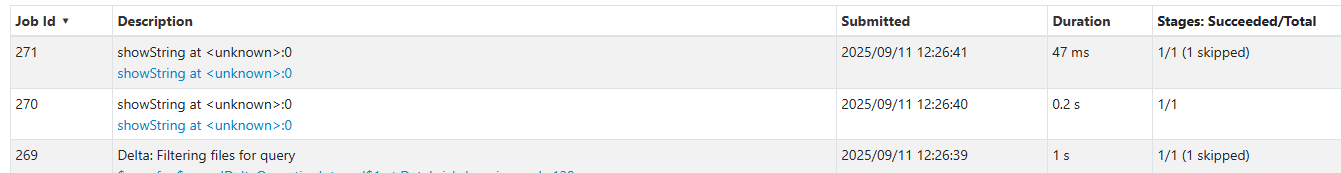

**<font color="red">Temps exécution = 1.25 secondes</font>**

Globalement, entre 2 véhicules de la marque Mercedes-Benz, mis en circulation la même année, l'un endommagé et l'autre non, le véhicule endommagé sera toujours moins cher que celui qui ne l'est pas.

Dans la majorité des marques et types de carburant, les véhicules sans dommages non réparés affichent un meilleur prix moyen et un kilométrage inférieur, confirmant leur meilleure valeur.


### Requête 2

Résumer le prix moyen et le nombre de véhicules par marque et type de carburant, en filtrant uniquement les immatriculations récentes (les 20 dernières années).

On effectue l'analyse en fonction également du statut endommagé.

In [ ]:
query_2 = """
SELECT
  brand,
  fuelType,
  notRepairedDamage,
  COUNT(*) AS total_vehicles,
  AVG(price) AS avg_price,
  AVG(kilometer) AS avg_kilometers,
  MAX(yearOfRegistration) AS newest_vehicle_year
FROM deltaPrices
WHERE yearOfRegistration BETWEEN 1950 AND 1996
GROUP BY brand, fuelType, notRepairedDamage
ORDER BY brand, fuelType
"""
spark.sql(query_2).show(10)

+----------+--------+-----------------+--------------+------------------+------------------+-------------------+
|     brand|fuelType|notRepairedDamage|total_vehicles|         avg_price|    avg_kilometers|newest_vehicle_year|
+----------+--------+-----------------+--------------+------------------+------------------+-------------------+
|alfa_romeo|    NULL|             nein|             8|          16723.75|           87500.0|               1979|
|alfa_romeo|    NULL|               ja|             9| 5499.888888888889|109444.44444444444|               1995|
|alfa_romeo|  benzin|               ja|            35|10839.971428571429|102714.28571428571|               1996|
|alfa_romeo|  benzin|             nein|           107|13408.401869158879| 103925.2336448598|               1996|
|      audi|    NULL|               ja|            75|2443.5866666666666|139933.33333333334|               1996|
|      audi|    NULL|             nein|            62|3610.1129032258063|136451.61290322582|    

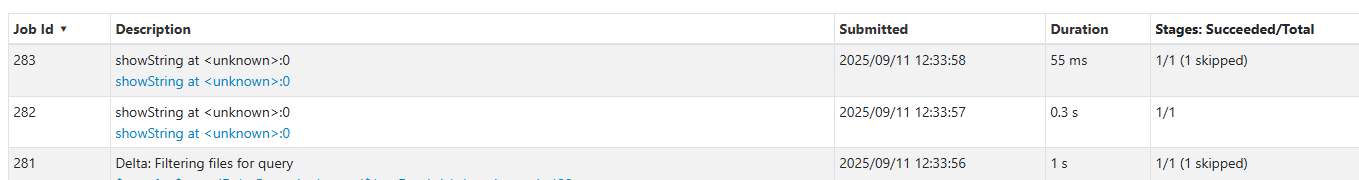

**<font color="red">Temps exécution = 1.35 secondes</font>**

Cette requête performante, et probablement couteuse, nous permet de constater l'impact de l'age, du type de carburant, de la marque sur le prix.

En effet, les voitures sans dommages non réparés ont un prix moyen plus élevé et un kilométrage plus faible, quel que soit le carburant ou la marque.

Les marques premium comme Audi et BMW affichent des prix bien supérieurs à des marques plus généralistes.

Les véhicules hybrides et électriques, bien que peu nombreux, sont généralement plus récents et beaucoup plus chers.

### Nouvelle organisation des données

Partitionner nos données selon les années de mise en circulation et selon la marque des véhicules pourrait nettement améliorer les performances de nos requêtes.

Nous allons vérifier cette hypothèse en relançant nos requêtes précédentes et comparant les performances avec ou sans partition.

In [ ]:
query = """
CREATE TABLE deltaPricesPerBrand USING DELTA PARTITIONED BY (brand)
AS SELECT * FROM deltaPrices
"""
spark.sql(query)

DataFrame[]

In [32]:
query = """
CREATE TABLE deltaPricesPerYearOfRegistration USING DELTA PARTITIONED BY (yearOfRegistration)
AS SELECT * FROM deltaPrices
"""
spark.sql(query)

DataFrame[]

### Requête 1 avec des partitions par marque

In [ ]:
query_1_with_part = """
SELECT brand, yearOfRegistration, notRepairedDamage,
       COUNT(*) count, AVG(price) avg_price, AVG(kilometer) avg_km
FROM deltaPricesPerBrand
WHERE yearOfRegistration BETWEEN 1950 AND 1996
AND brand in ('mercedes_benz','audi','fiat')
GROUP BY brand, yearOfRegistration, notRepairedDamage
ORDER BY brand , yearOfRegistration DESC
"""
spark.sql(query_1_with_part).show(10)

+-----+------------------+-----------------+-----+------------------+------------------+
|brand|yearOfRegistration|notRepairedDamage|count|         avg_price|            avg_km|
+-----+------------------+-----------------+-----+------------------+------------------+
| audi|              1996|             nein|  400|         2342.3925|          146850.0|
| audi|              1996|               ja|  114|1945.6315789473683| 143157.8947368421|
| audi|              1995|             nein|  262|            2290.0|144122.13740458016|
| audi|              1995|               ja|   91|2392.6813186813188| 143296.7032967033|
| audi|              1994|             nein|  160|        3043.53125|          143250.0|
| audi|              1994|               ja|   59|2330.5593220338983|146016.94915254237|
| audi|              1993|             nein|  135|2712.2444444444445|144629.62962962964|
| audi|              1993|               ja|   32|          2502.375|          146250.0|
| audi|              

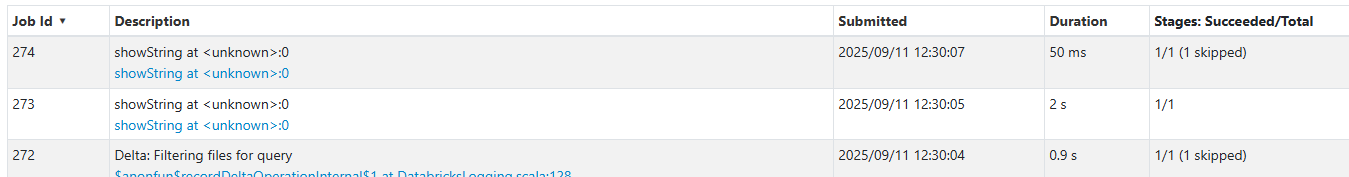

**<font color="red">Temps exécution = 1.15 secondes</font>**

### Requête 2 avec des partitions par année de mise en circulation

In [ ]:
query_2_with_part = """
SELECT
  brand,
  fuelType,
  notRepairedDamage,
  COUNT(*) AS total_vehicles,
  AVG(price) AS avg_price,
  AVG(kilometer) AS avg_kilometers,
  MAX(yearOfRegistration) AS newest_vehicle_year
FROM deltaPricesPerYearOfRegistration
WHERE yearOfRegistration BETWEEN 1950 AND 1996
GROUP BY brand, fuelType, notRepairedDamage
ORDER BY brand, fuelType
"""
spark.sql(query_2_with_part).show(10)

+----------+--------+-----------------+--------------+------------------+------------------+-------------------+
|     brand|fuelType|notRepairedDamage|total_vehicles|         avg_price|    avg_kilometers|newest_vehicle_year|
+----------+--------+-----------------+--------------+------------------+------------------+-------------------+
|alfa_romeo|    NULL|             nein|             8|          16723.75|           87500.0|               1979|
|alfa_romeo|    NULL|               ja|             9| 5499.888888888889|109444.44444444444|               1995|
|alfa_romeo|  benzin|               ja|            35|10839.971428571429|102714.28571428571|               1996|
|alfa_romeo|  benzin|             nein|           107|13408.401869158879| 103925.2336448598|               1996|
|      audi|    NULL|             nein|            62|3610.1129032258063|136451.61290322582|               1996|
|      audi|    NULL|               ja|            75|2443.5866666666666|139933.33333333334|    

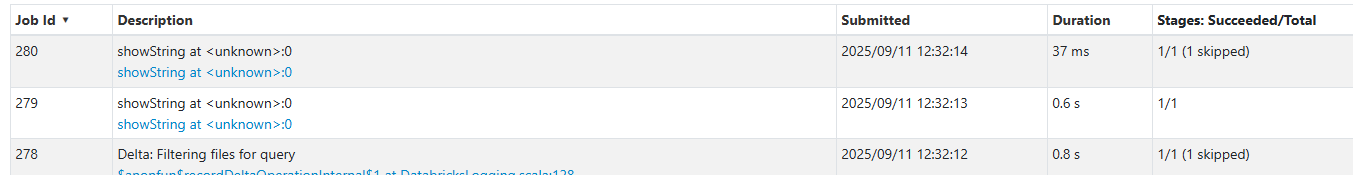

**<font color="red">Temps exécution = 1.43 secondes</font>**

## Ingestion de nouvelles données et relance des analyses.

In [ ]:
query = """
CREATE TABLE deltaPricesCDF USING DELTA TBLPROPERTIES (delta.enableChangeDataFeed = true)
AS SELECT * FROM deltaPrices
"""
spark.sql(query)

DataFrame[]

In [ ]:
query = """
INSERT INTO deltaPricesCDF
SELECT
  id + 1000000 AS id,
  dateCreated,
  price,
  yearOfRegistration,
  notRepairedDamage,
  powerPSCat,
  kilometer,
  fuelType,
  vehiculeType,
  gearbox,
  model,
  abtest,
  brand,
  department,
  lastSeen
FROM deltaPricesCDF
"""
spark.sql(query).show(10)

++
||
++
++



### Visualisation de l'évolution de la base au fil des requêtes.

In [ ]:
query = """
DESCRIBE HISTORY deltaPricesCDF
"""
spark.sql(query).show()

+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|           timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+--------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      1|2025-09-11 15:19:...|  NULL|    NULL|               WRITE|{mode -> Append, ...|NULL|    NULL|     NULL|          0|  Serializable|        false|{numFiles -> 2, n...|        NULL|Apache-Spark/3.5....|
|      0|2025-09-11 15:18:...|  NULL|    NULL|CREATE TABLE AS S...|{isManaged -> tru...|NULL|    NULL|     NULL|       NULL|  Serializable|         true|{numFiles -

In [ ]:
query = """
WITH v1 AS (
  SELECT AVG(price) AS avg_price_v1
  FROM deltaPricesCDF VERSION AS OF 1
),
v0 AS (
  SELECT AVG(price) AS avg_price_v0
  FROM deltaPricesCDF VERSION AS OF 0
)

SELECT
  v1.avg_price_v1,
  v0.avg_price_v0,
  v1.avg_price_v1 - v0.avg_price_v0 AS price_difference
FROM v1, v0
"""
spark.sql(query).show()

+-----------------+-----------------+----------------+
|     avg_price_v1|     avg_price_v0|price_difference|
+-----------------+-----------------+----------------+
|7384.774565361504|7384.774565361504|             0.0|
+-----------------+-----------------+----------------+



Nous obtenons un résultat logique étant donné que ce sont exactement les mêmes données qui ont été insérées. La moyenne reste donc inchangée.

Voyons ce qu'il en est du nombre d'enregistrement, lui, il a du doublé puisque nous avons dupliquer toutes les lignes de la table deltaPrices.

In [ ]:
query = """
WITH v1 AS (
  SELECT count(price) AS count_price_v1
  FROM deltaPricesCDF VERSION AS OF 1
),
v0 AS (
  SELECT count(price) AS count_price_v0
  FROM deltaPricesCDF VERSION AS OF 0
)

SELECT
  v1.count_price_v1,
  v0.count_price_v0,
  v1.count_price_v1 - v0.count_price_v0 AS count_difference
FROM v1, v0
"""
spark.sql(query).show()

+--------------+--------------+----------------+
|count_price_v1|count_price_v0|count_difference|
+--------------+--------------+----------------+
|       1122312|        561156|          561156|
+--------------+--------------+----------------+



Nous voyons bien qu'entre les 2 versions de la table, le nombre d'enregistrements a doublé comme attendu.